# Dog Breed - Full dataset, ensemble, 5 crop, pseudo labelling

In [1]:
import glob

import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import xception
from keras.utils import to_categorical

from keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import StratifiedKFold

%matplotlib inline

Using TensorFlow backend.


It seems like the only way to make it to the top of the leaderboard is to use the full Stanford Dogs dataset. The first and the third have admitted to it. So let's try it.

Obviously, the thinking is that there's going to be near 100% overlap with the dataset used here and the test set, so we might as well use it.

In [ ]:
% cd ./data
% wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
% tar --extract --file ./images.tar

In [3]:
img = Image.open('./data/fullset/Images/n02085936-Maltese_dog/n02085936_10073.jpg')

## Load training data

In [2]:
labels = pd.read_csv('./data/labels.csv')

In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
id_to_label = {i: label for i, label in enumerate(sorted(labels.breed.unique()))}
label_to_id = {label: i for i, label in id_to_label.items()}

num_classes = len(labels.breed.unique())
img_size = (299, 299)

In [5]:
n = len(glob.glob('./data/fullset/Images/**/*.jpg', recursive=True))

X = np.zeros((n,) + img_size + (3,), dtype=np.uint8)
Y = np.zeros((n, num_classes), dtype=np.uint8)

for i, filename in tqdm_notebook(enumerate(glob.iglob('./data/fullset/Images/**/*.jpg', recursive=True)), total=n):
    filepath = filename
    
    label = filepath.split('/')[-2][10:]
    label = label.lower()
    
    img = Image.open(filepath)
    if img.mode != 'RGB':
        img = img.convert('RGB')
        
    img = img.resize(img_size)

    label_id = label_to_id[label]

    X[i] = np.asarray(img)
    Y[i][label_id] = 1

HBox(children=(IntProgress(value=0, max=20580), HTML(value='')))

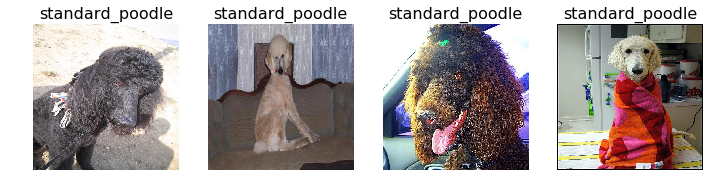

In [6]:
f = plt.figure(figsize=(12, 6))

for i in range(4):
    sp = f.add_subplot(2, 4, i+1)
    sp.axis('Off')
    sp.set_title(id_to_label[np.argmax(Y[i])], fontsize=16)
    plt.imshow(X[i])

In [18]:
def get_bottleneck_features(data, batch_size=64, img_size=(299, 299)):
    input_shape = img_size + (3,)

    base_model = xception.Xception(
        include_top=False, input_shape=input_shape, weights='imagenet')

    inp = Input(input_shape)
    x = Lambda(xception.preprocess_input, name='preprocessing')(inp)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    cnn_model = Model(inp, outputs=x)

    return cnn_model.predict(data, batch_size=batch_size, verbose=1)


def get_model(shape, num_classes, dropout=0.5):
    inputs = Input(shape)
    x = Dropout(dropout)(inputs)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
features = get_bottleneck_features(X)

20580/20580 [==============================] - 465s 23ms/step


## Xception

In [20]:
# Presumably I want the model to overfit as much as possible, since we are training on the test data.
model = get_model(features.shape[1:], num_classes, dropout=0)
    
callbacks = [
    ReduceLROnPlateau(patience=3, verbose=1),
    EarlyStopping(patience=20)]

indexes = np.random.permutation(len(features))

res = model.fit(
    features[indexes], Y[indexes], batch_size=64, epochs=40, validation_split=0.1, callbacks=callbacks)

Train on 18522 samples, validate on 2058 samples
Epoch 1/40
18522/18522 [==============================] - 2s 90us/step - loss: 0.9319 - acc: 0.8366 - val_loss: 0.3472 - val_acc: 0.8965
Epoch 2/40
18522/18522 [==============================] - 1s 58us/step - loss: 0.2842 - acc: 0.9183 - val_loss: 0.3077 - val_acc: 0.9009
Epoch 3/40
18522/18522 [==============================] - 1s 57us/step - loss: 0.2294 - acc: 0.9322 - val_loss: 0.2955 - val_acc: 0.9043
Epoch 4/40
18522/18522 [==============================] - 1s 57us/step - loss: 0.1965 - acc: 0.9404 - val_loss: 0.2846 - val_acc: 0.9086
Epoch 5/40
18522/18522 [==============================] - 1s 57us/step - loss: 0.1721 - acc: 0.9481 - val_loss: 0.2891 - val_acc: 0.9048
Epoch 6/40
18522/18522 [==============================] - 1s 57us/step - loss: 0.1529 - acc: 0.9549 - val_loss: 0.2922 - val_acc: 0.9057
Epoch 7/40
18522/18522 [==============================] - 1s 57us/step - loss: 0.1361 - acc: 0.9606 - val_loss: 0.2947 - val_acc:

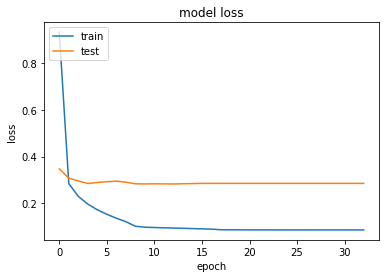

In [21]:
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Xception Ensemble with 10 folds


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


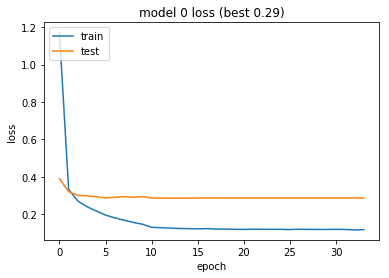


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


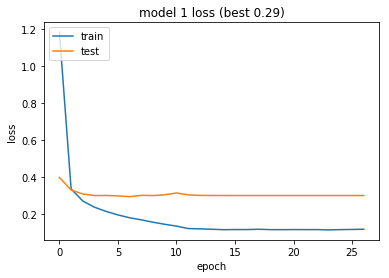


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


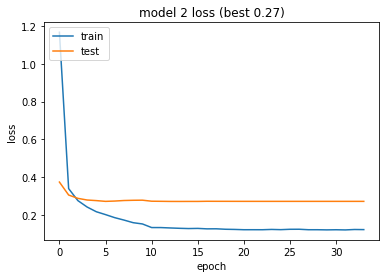


Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


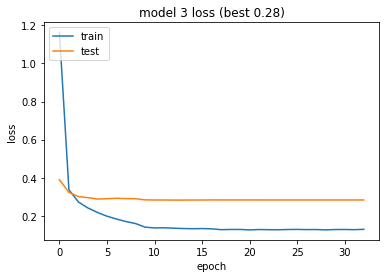


Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


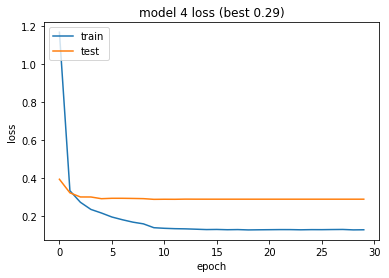


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


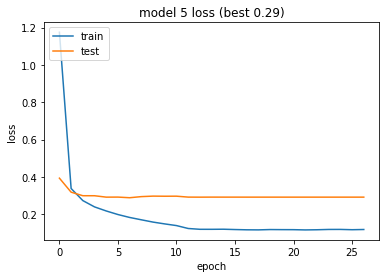


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


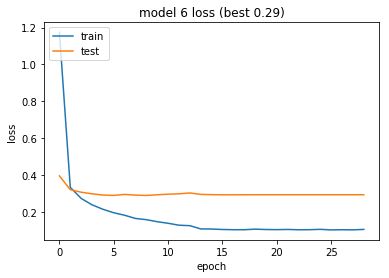


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.


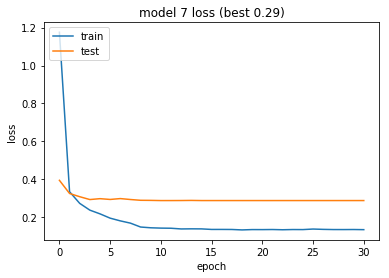


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


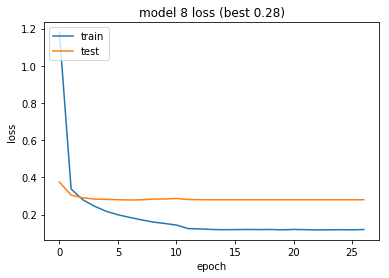


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.


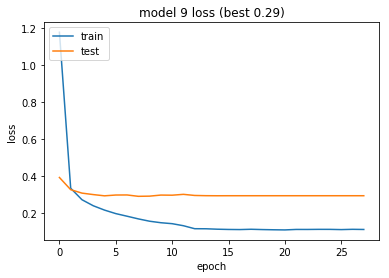

In [22]:
num_models = 10

for i in range(num_models):
    model_path = f'./checkpoints/xception_ens_fullset_{i}.h5'
    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True),
        ReduceLROnPlateau(patience=3),
        EarlyStopping(patience=20)]
    
    model = get_model(features.shape[1:], num_classes)
    
    indexes = np.random.permutation(len(features))
    
    res = model.fit(
        features[indexes], Y[indexes], batch_size=64, epochs=40,
        validation_split=0.2, verbose=False, callbacks=callbacks)
    
    best_loss = round(min(res.history['val_loss']), 2)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.title(f'model {i} loss (best {best_loss})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
def get_test_inputs(sample_df):
    n_test = len(sample_df)
    X_test = np.zeros((n_test,) + img_size + (3,), dtype=np.uint8)
    for i, row in tqdm_notebook(enumerate(sample_df.itertuples()), total=n_test):
        item_id = row.id

        img = Image.open(f'./data/test/unknown/{item_id}.jpg').resize(img_size)

        label_id = label_to_id[label]

        X_test[i] = np.asarray(img)
        
    return X_test

In [24]:
sample_df = pd.read_csv('./data/sample_submission.csv')

In [25]:
X_test = get_test_inputs(sample_df)

HBox(children=(IntProgress(value=0, max=10357), HTML(value='')))

In [27]:
test_features = get_bottleneck_features(X_test)

10357/10357 [==============================] - 234s 23ms/step


In [28]:
model = get_model(features.shape[1:], num_classes)

predictions = []

for i in range(10):
    model.load_weights(f'./checkpoints/xception_ens_fullset_{i}.h5')
    p = model.predict(test_features)
    predictions.append(p)
    
avg_preds = np.stack(predictions).mean(axis=0)

In [29]:
for i in range(num_classes):
    sample_df[id_to_label[i]] = avg_preds[:,i]

In [30]:
sample_df.to_csv('./submissions/xception_standord_set_ensemble.csv', index=None)

That takes me to 0.14668. Top 100 :)